###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  

# Riding the wave

## Sod's test problems

Sod's test problems are standard benchmarks used to assess the accuracy of numerical solvers. The tests use a classic example of one-dimensional compressible flow: the shock-tube problem. Sod (1978) chose initial conditions and numerical discretization parameters for the shock-tube problem and used these to test several schemes, including Lax-Wendroff and MacCormack's. Since then, many others have followed Sod's example and used the same tests on new numerical methods.

The shock-tube problem is so useful for testing numerical methods because it is one of the few problems that allows an exact solution of the Euler equations for compressible flow.

This notebook complements the previous lessons of the course module [_"Riding the wave: convection problems"_](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/03_wave) with Sod's test problems as an independent coding exercise. We'll lay out the problem for you, but leave important bits of code for you to write on your own. Good luck!

### What's a shock tube?

A shock tube is an idealized device that generates a one-dimensional shock wave in a compressible gas. The setting allows an analytical solution of the Euler equations, which is very useful for comparing with the numerical results to assess their accuracy. 

Picture a tube with two regions containing gas at different pressures, separated by an infinitely-thin, rigid diaphragm. The gas is initially at rest, and the left region is at a higher pressure than the region to the right of the diaphragm. At time $t = 0.0 s$, the diaphragm is ruptured instantaneously.  

What happens?  

You get a shock wave.  The gas at high pressure, no longer constrained by the diaphragm, rushes into the lower-pressure area and a one-dimensional unsteady flow is established, consisting of:

* a shock wave traveling to the right
* an expansion wave traveling to the left
* a moving contact discontinuity

The shock-tube problem is an example of a *Riemann problem* and it has an analytical solution, as we said. The situation is illustrated in Figure 1.

![shocktube](./figure/shocktube.png)
#### Figure 1. The shock-tube problem.

### The Euler equations

The Euler equations govern the motion of an inviscid fluid (no viscosity). They consist of the conservation laws of mass and momentum, and often we also need to work with the energy equation. 

Let's consider a 1D flow with velocity $u$ in the $x$-direction. The Euler equations for a fluid with density $\rho$ and pressure $p$ are:

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u) &= 0 \\
\frac{\partial}{\partial t}(\rho u) + \frac{\partial}{\partial x} (\rho u^2 + p)&=0
\end{align}

... plus the energy equation, which we can write in this form:

\begin{equation}
\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x} (\rho u e_T +p u)=0
\end{equation}
where $e_T=e+u^2/2$ is the total energy per unit mass, equal to the internal energy plus the potential energy (per unit mass).

Written in vector form, you can see that the Euler equations bear a strong resemblance to the traffic-density equation that has been the focus of this course module so far. Here is the vector representation of the Euler equation:

\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}

The big difference with our previous work is that the variables $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ are *vectors*.  If you review the [Phugoid Full Model](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb) lesson, you will recall that we can solve for several values at once using the vector form of an equation.  In the Phugoid Module, it was an ODE—now we apply the same procedure to a PDE.  

Let's take a look at what $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ consist of.  

### The conservative form

Many works in the early days of computational fluid dynamics in the 1960s showed that using the conservation form of the Euler equations is more accurate for situations with shock waves.  And as you already saw, the shock-tube solutions do contain shocks.

The conserved variables $\underline{\mathbf{u}}$ for Euler's equations are

\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]\end{equation}

where $\rho$ is the density of the fluid, $u$ is the velocity of the fluid and $e_T = e + \frac{u^2}{2}$ is the specific total energy; $\underline{\mathbf{f}}$ is the flux vector:

\begin{equation}\underline{\mathbf{f}} = \left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u \\ \end{array} \right]
\end{equation}

where $p$ is the pressure of the fluid.

If we put together the conserved variables and the flux vector into our PDE, we get the following set of equations:

\begin{equation}
\frac{\partial}{\partial t}
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]
+ \frac{\partial}{\partial x}
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u\\ \end{array}
\right]
=0
\end{equation}

There's one major problem there.  We have 3 equations and 4 unknowns.  But there is a solution!  We can use an equation of state to calculate the pressure—in this case, we'll use the ideal gas law.

### Calculating the pressure

For an ideal gas, the equation of state is

$$e = e(\rho, p) = \frac{p}{(\gamma -1) \rho},$$

where $\gamma = 1.4$ is a reasonable value to model air, 

$$\therefore p = (\gamma -1)\rho e. $$ 

Recall from above that

$$e_T = e+\frac{1}{2} u^2$$

$$\therefore e = e_T - \frac{1}{2}u^2.$$

Putting it all together, we arrive at an equation for the pressure

$$p = (\gamma -1)\left(\rho e_T - \frac{\rho u^2}{2}\right).$$

### Flux in terms of $\underline{\mathbf{u}}$

With the traffic model, the flux was a function of traffic density.  For the Euler equations, the three equations we have are coupled and the flux *vector* is a function of $\underline{\mathbf{u}}$, the vector of conserved variables:

$$\underline{\mathbf{f}} = f(\underline{\mathbf{u}})$$

In order to get everything squared away, we need to represent $\underline{\mathbf{f}}$ in terms of $\underline{\mathbf{u}}$.
We can introduce a little shorthand for the $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ vectors and define:


$$\underline{\mathbf{u}} = 
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\ 
\end{array} \right] =
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]$$

$$\underline{\mathbf{f}} = 
\left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u\\ \end{array}
\right]
$$  


With a little algebraic trickery, we can represent the pressure vector using quantities from the $\underline{\mathbf{u}}$ vector.

$$p = (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right)$$

Now that pressure can be represented in terms of $\underline{\mathbf{u}}$, the rest of $\underline{\mathbf{f}}$ isn't too difficult to resolve:

$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$

## Test conditions

The first test proposed by Sod in his 1978 paper is as follows.  

In a tube spanning from $x = -10 \text{m}$ to $x = 10 \text{m}$ with the rigid membrane at $x = 0 \text{m}$, we have the following initial gas states:

$$\underline{IC}_L = \left[ \begin{array}{c}
\rho_L \\ u_L \\ p_L \\ \end{array}\right] = 
\left[ \begin{array}{c}
1\ kg/m^3 \\ 0\ m/s \\ 100\ kN/m^2 \\ \end{array}\right]$$

$$\underline{IC}_R = \left[ \begin{array}{c}
\rho_R \\ u_R \\ p_R \\ \end{array}\right] = 
\left[ \begin{array}{c}
0.125\ kg/m^3 \\ 0\ m/s \\ 10\ kN/m^2 \\ \end{array}\right]$$

where $\underline{IC}_L$ are the initial density, velocity and pressure on the left side of the tube membrane and $\underline{IC}_R$ are the initial density, velocity and pressure on the right side of the tube membrane.  

The analytical solution to this test for the velocity, pressure and density, looks like the plots in Figure 2.

![shock_analytic](./figure/shock_tube_.01.png)
. 

#### Figure 2. Analytical solution for Sod's first test.

### The Richtmyer method

For this exercise, you will be using a new scheme called the Richtmyer method.  Like the MacCormack method that we learned in [lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb), Richtmyer is a *two-step method*, given by:

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}


The flux vectors used in the second step are obtained by evaluating the flux functions on the output of the first step:

$$\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$

The first step is like a *predictor* of the solution: if you look closely, you'll see that we are applying a Lax-Friedrichs scheme here. The second step is a *corrector* that applies a leapfrog update. Figure 3 gives a sketch of the stencil for Richmyer method, where the "intermediate time" $n+1/2$ will require a temporary variable in your code, just like we had in the MacCormack scheme.


![richtmyer](./figure/richtmyer.png)


#### Figure 3. Stencil of Richtmyer scheme.

## Coding assignment

Your mission, should you wish to accept it, is to calculate the pressure, density and velocity across the shock tube at time $t = 0.01 s$ using the Richtmyer method. Good luck!

## Reference

* Sod, Gary A. (1978), "A survey of several finite difference methods for systems of nonlinear hyperbolic conservation laws," *J. Comput. Phys.*, Vol. 27, pp. 1–31 DOI: [10.1016/0021-9991(78)90023-2](http://dx.doi.org/10.1016%2F0021-9991%2878%2990023-2) // [PDF from unicamp.br](http://www.fem.unicamp.br/~phoenics/EM974/TG%20PHOENICS/BRUNO%20GALETTI%20TG%202013/a%20survey%20of%20several%20finite%20difference%20methods%20for%20systems%20of%20nonlinear%20hyperbolic%20conservation%20laws%20Sod%201978.pdf), checked Oct. 28, 2014.

---


# Travail

## Introduction

Nous allons travailler avec un tableau $\underline{\mathbf{A}}$ qui contient les valeurs de la densité $\rho$, la vitesse $u$ et la pression $p$ selon la variable spatiale déterminant le point considéré dans le tube. Nous pourrons manipuler facilement ce tableau, montrer un graphique de l'évolution des différentes variables dans l'espace et dans le temps, et trouver réponses aux questions posées dans le devoir.

La méthode Richtmyer que nous devons utilisés nous demande de manipuler les vecteurs $\underline{\mathbf{u}}$ et $\underline{\mathbf{f}}$, ce que nous ferons avec les fonctions $vector_u()$ et $vector_f()$. Elles nous permettent facilement d'obtenir les vecteurs $\underline{\mathbf{u}}$ et $\underline{\mathbf{f}}$ à l'aide du tableau $\underline{\mathbf{A}}$ des valeurs de $\rho$, $u$ et $p$, l'inverse est aussi possible grace à la fonction $basic()$. Leur fonctionnement est bien sur expliqué quelques cellules plus loin


$$
\begin{align}
\underline{\mathbf{A}} & = \left[\begin{array}{c} \rho \\\\ u \\\\ p \\ \end{array} \right] &
\underline{\mathbf{u}} & = \left[\begin{array}{c} \rho \\\\ \rho u \\\\ \rho e_T \\ \end{array} \right] &
\underline{\mathbf{f}} & = \left[\begin{array}{c} f_1 \\\\ f_2 \\\\ f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
\rho u \\\\
\rho u^2 + p \\\\
(\rho e_T + p) u\\ \end{array}
\right]
\end{align}
$$



In [1]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

Avec le tableau $\underline{\mathbf{A}}$ nous pouvons obtenir les vecteurs $\underline{\mathbf{u}}$ et $\underline{\mathbf{f}}$ grace aux formules développées dans l'explication du travail. Nous utilisons les équations suivantes pour ces deux fonctions

$$
\begin{align}
\underline{\mathbf{u}} & = \left[\begin{array}{c} \rho \\\\ \rho u \\\\ \rho e_T \\ \end{array} \right] &
\underline{\mathbf{f}} & = \left[\begin{array}{c} f_1 \\\\ f_2 \\\\ f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\\\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]
\end{align}
$$

Sachant que 
$$
e_T = e+\frac{1}{2} u^2 = \frac{p}{(\gamma -1) \rho}+\frac{1}{2} u^2
$$

Le vecteur $\underline{\mathbf{f}}$ est donc défini à partir de $\underline{\mathbf{u}}$, il est donc utilisé dans sa fonction $vector_f()$ alors que la fonction $vector_u()$ est définie à partir de $\underline{\mathbf{A}}$

In [2]:
def vector_u(array,gamma):
    """Transform the array of float "array" to get the vector u
    
    Parameters
    ----------
    array : array of float
        array containing the values of (rho,u,p)
    gamma : float
        constant from the exercise
    
        
    Returns
    -------
    vector u : array of float
        array containing the equations of the vector u
    """
    
    rho = array[0]
    u = array[1]
    p = array[2]
    e_t = p/((gamma-1)*rho)+.5*u**2
    return numpy.array([rho,
                      rho*u,
                      rho*e_t])

In [3]:
def vector_f(u, gamma):
    """Transform the array of float "u" to get the vector f
    
    Parameters
    ----------
    u : array of float
        array containing the equations of the vector u
    gamma : float
        constant from the exercise
    
        
    Returns
    -------
    vector f : array of float
        array containing the equations of the vector f
    """
    
    u_1 = u[0]
    u_2 = u[1]
    u_3 = u[2]

    return numpy.array([u_2,
                      u_2**2/u_1+(gamma-1)*(u_3-.5*u_2**2/u_1),
                      (u_3+(gamma-1)*(u_3-.5*u_2**2/u_1))*u_2/u_1])

Et enfin si nous avons le vecteur $\underline{\mathbf{u}}$ il nous faut une autre fonction nous permettant de faire marche arrière pour obtenir les valeurs de $\underline{\mathbf{A}}$. C'est là le but de la fonction $basic()$ qui se base sur les équations suivantes, développée dans l'explicatif du travail

$$\underline{\mathbf{A}} = \left[ \begin{array}{c}
u_1\\
\frac{u_2}{u_1} \\
(\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right)\\ \end{array}
\right]
$$

Cette fonction sera utile surtout après la fonction $dothemath()$ qui effectue la simulation du Shock Tube pour un certain temps. Cette fonction $dothemath()$ va manipuler les vecteurs $\underline{\mathbf{u}}$ et $\underline{\mathbf{f}}$ un nombre $nt$ de fois et elle va "sauvegarder" la valeur de $\underline{\mathbf{u}}$ pour chaque manipulation nt dans un tableau aux dimensions (nt,3,nx). C'est pour ça que pour "traduire" le tableau $\underline{\mathbf{u}}$ en $\underline{\mathbf{A}}$ nous utilisons le tableau $initial$ avec les dimensions citées.

In [4]:
def basic(u,nt,nx,gamma):
    """Transform the array of float "u" to get the vector A
    
    Parameters
    ----------
    u : array of float
        array containing the solution of vector u
    nt : float
        number of grid points in t
    nx : float
        number of grid points in x
    gamma : float
        constant from the exercise
    
        
    Returns
    -------
    initial : array of float
        array containing the values of (rho,u,p) throught the whole simulation time
    
    """
    initial = numpy.zeros((nt,3,nx))
    for t in range(nt):
        u_1 = u[t][0]
        u_2 = u[t][1]
        u_3 = u[t][2]
        initial[t] = numpy.array([u_1,u_2/u_1,(gamma-1)*(u_3-.5*u_2**2/u_1)])
    return initial

## Functions initiales

Introduisons maintenant la fonction qui va crée $\underline{\mathbf{A}}$ selon les conditions initiales. Nous faisons en sorte que les dites conditions sont bien des paramètres de la fonction, cela nous assure de pouvoir les modifier à notre guise. Nous avons juste fixé la membrane rigide comme étant au centre du tube grace à la variable $middle$.

In [5]:
def shocktube(nx, cdt_left, cdt_right):
    """Computes initial condition with shock tube

    Parameters
    ----------
    nx         : int
        Number of grid points in x
    cdt_left   : list of float
        condition on the left side of the tube with elements (density,velocity,pressure)
    cdt_right  : list of float
        condition on the right side of the tube with elements (density,velocity,pressure)

    Returns
    -------
    array      : array of floats
        Array with initial values of density, velocity and pressure 
    """
    x = numpy.ones(nx)
    
    middle = int((nx-1)/2)
    
    rho = x.copy()*cdt_left[0]
    rho[middle:] = cdt_right[0]
    
    u = x.copy()*cdt_left[1]
    u[middle:] = cdt_right[1]
    
    p = x.copy()*cdt_left[2]
    p[middle:] = cdt_right[2]
    
    array = numpy.array([rho,u,p])
    
    return array

Nous entrons maintenant les paramètres du codes, les conditions initiales et les conditions de bords. Les coniditons initiales de bords sont regroupées dans une liste afin d'être utilisé correctement par la fonction $shocktube()$

In [6]:
#Basic code parameters
nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4

#These are included so we don't have to calculate the value of nt (we are getting really lazy)
T = 0.01             # time considered for the simulation
nt = int(T/dt)+1     # number of time steps

# Initial boundary conditons
### from -10 to 0 m inside the tube (left side)
rho_left = 1.        # density in kg m^{-3}
u_left = 0           # velocity in m/s
p_left = 100000      # pressure in kg m^{-2}
## from 0 to 10m inside the tube (right side)
rho_right = 0.125    # density in kg m^{-3}
u_right = 0          # velocity in m/s
p_right = 10000      # pressure in kg m^{-2}

# Boundaries list used with the function shocktube()
condition_left = [rho_left,u_left,p_left]
condition_right = [rho_right,u_right,p_right]

Pour vérifier notre travail fait jusqu'à présent nous regardons la graphique de notre vecteur $\underline{\mathbf{A}}$

In [7]:
A = shocktube(nx,condition_left,condition_right)

In [8]:
# the spatial grid is onle needed for the graphics
x = numpy.linspace(-10,10,nx)

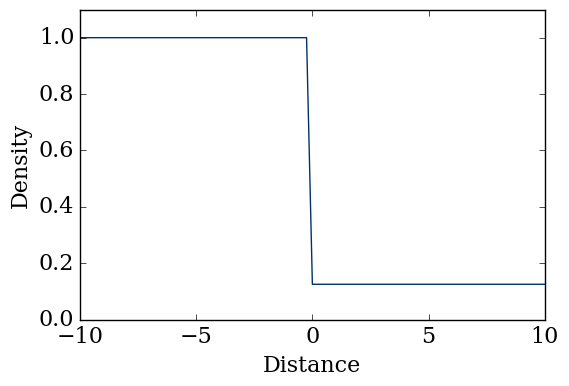

In [9]:
pyplot.plot(x, A[0], color='#003366', ls='-', lw=1)
pyplot.ylabel('Density')
pyplot.xlabel('Distance')
pyplot.ylim(0,1.1);

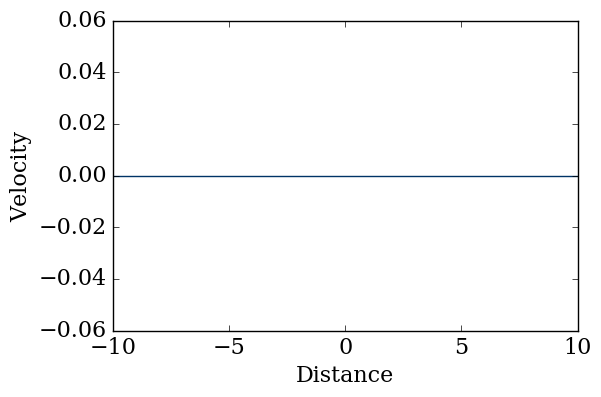

In [10]:
pyplot.plot(x, A[1], color='#003366', ls='-', lw=1)
pyplot.ylabel('Velocity')
pyplot.xlabel('Distance')

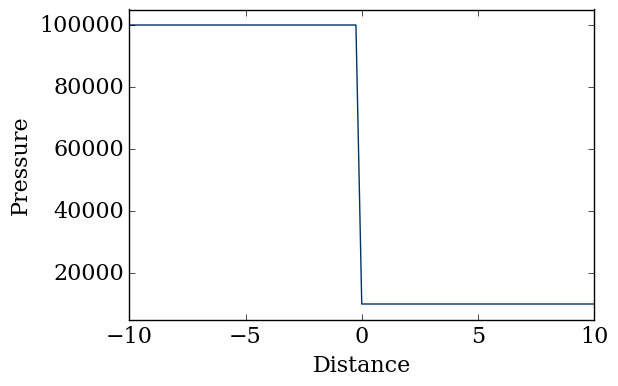

In [11]:
pyplot.plot(x, A[2], color='#003366', ls='-', lw=1)
pyplot.ylabel('Pressure')
pyplot.xlabel('Distance')
pyplot.ylim(5000,105000);

## Simulation Richtmyer

Le tableau $\underline{\mathbf{A}}$ a bien été formulé, nous pouvons maintenant passer à la fonction principale du travail, celle qui va simuler le comportement du gaz compressible dans le tube à l'aide de la méthode Richtmyer. Nous utilisons ces équations décrites dans l'intulé de l'exercice afin d'écrire notre fonction

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}


$$\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$


Il ne faut bien sur pas oublier les conditions de bords qui sont manifestées par les deux avant dernières lignes de code de la fonction.

In [12]:
def dothemath(array, nt, nx, dt, dx, gamma):
    """ Computes the solution with Richtmyer scheme
    
    Parameters
    ----------
    array  : array of floats
            Array with initial values of density, velocity and pressure
    nt     : int
            Number of grid points in t
    nx     : int
            Number of grid points in x
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing

    
    Returns
    -------
    u      : array of floats
            Array with values of vector u at every nt time steps at every point x
            
    We directly transform the array u with the function basic() to get the vector A wich we can manipulate easily
    """
    u = numpy.zeros((nt,3,nx))
    u[0] = vector_u(array,gamma)
    
    for t in range(nt-1): 
        un = u[t]
        f = vector_f(un,gamma)
        
        u_star = 0.5*(un[:,1:]+un[:,:-1])-dt/(2*dx) * (f[:,1:]-f[:,:-1])
        
        f_star = vector_f(u_star,gamma)
        u[t+1][:,1:-1] = un[:,1:-1] - dt/dx*(f_star[:,1:] - f_star[:,:-1])
        
        u[t+1][:,0] = un[:,0]
        u[t+1][:,-1] = un[:,-1]
                
    return basic(u,nt,nx,gamma)

In [13]:
a = dothemath(A,nt,nx,dt,dx,gamma)

La variable a est maintenant un tableau de dimension (51,3,81) où $a[0]$ correspond au vecteur $\underline{A}$ qui représente le tableau des valeurs de $(\rho,u,p)$ initial. Pour avoir le tableau des valeurs de $(\rho,u,p)$ après $t=0,1s$ il suffit d'utiliser $a[50]=a[-1]$.


Nous montrons sur graphique à quoi ressemble $(\rho,u,p)$ après le temps de simulation.

In [14]:
a.shape

(51, 3, 81)

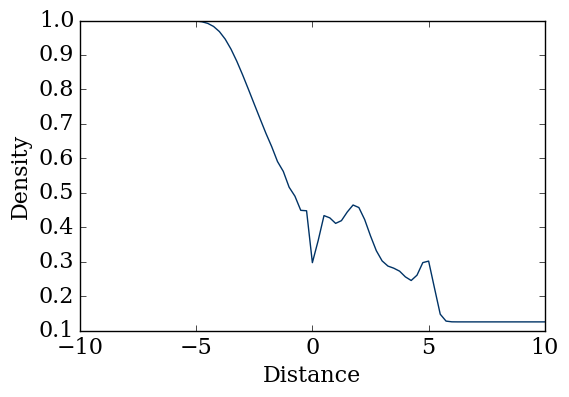

In [15]:
pyplot.plot(x, a[50][0], color='#003366', ls='-', lw=1)
pyplot.ylabel('Density')
pyplot.xlabel('Distance')

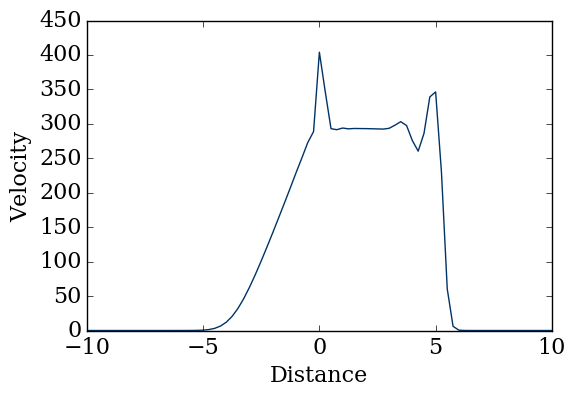

In [16]:
pyplot.plot(x, a[50][1], color='#003366', ls='-', lw=1)
pyplot.ylabel('Velocity')
pyplot.xlabel('Distance')

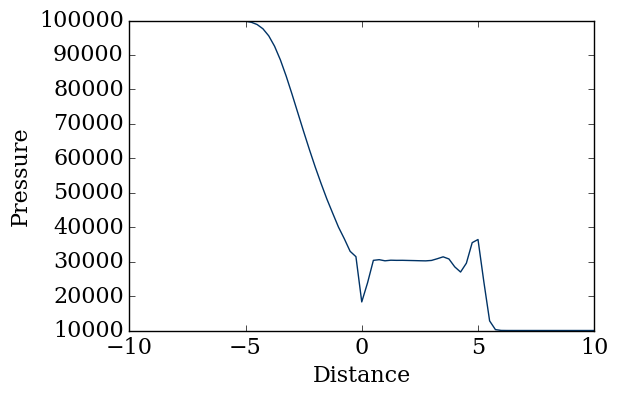

In [17]:
pyplot.plot(x, a[50][2], color='#003366', ls='-', lw=1)
pyplot.ylabel('Pressure')
pyplot.xlabel('Distance')

Nous obtenons des graphes très curieux concernant le comportement des 3 variables et pour pouvoir interpréter correctement ceux ci il serait plus judicieux d'obtenir l'animation de l'évolution du comportement de ces variables selon le temps.

Et maintenant nous donnons les solutions des questions demandées pour le devoir. Le point $x=2,5m$ correspond à la 50ème valeur du tableau $a[50]$

In [18]:
a[50,:,50]

array([  3.74691403e-01,   2.92611472e+02,   3.02508902e+04])

Ainsi après un temps $t=0,1s$ à $x=2,5m$ nous savons que :
 - la densite $\rho = 0,37 \frac{kg}{m^3}$
 
 - la vitesse $u = 292,61 \frac{m}{s}$
 
 - la pression $p = 30250,89 \frac{kg}{m^2}$

## Animation

Nous avons voulu animer l'évolution des variables $(\rho,u,p)$ au cours du temps pour pouvoir interpréter le comportement de ces variables dans cet exercice. La façon dont est construite notre fonction $dothemath()$ nous permet directement de l'utiliser pour les animations. 

Par soucis d'échelle et de dimension de la figure nous n'avons pas trouvé de moyen d'utiliser la même figure "fig" pour les 3 graphes, nous avons donc du la déclarer à nouveau avant chaque animation.

In [19]:
def animate(data):
    x = numpy.linspace(-10,10,nx)
    y = data
    line.set_data(x,y)
    return line,

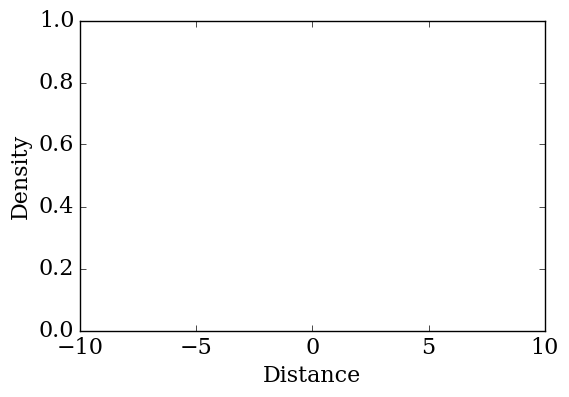

In [20]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(0,1.),xlabel=('Distance'),ylabel=('Density'));
line, = ax.plot([],[],color='#003366', lw=2);

Nous relançons une dernière fois la simulation pour effectuer les animations

In [21]:
A = shocktube(nx,condition_left,condition_right)
A_n = dothemath(A,nt,nx,dt,dx,gamma)

In [22]:
anim = animation.FuncAnimation(fig, animate, frames=A_n[:,0], interval=50)
HTML(anim.to_html5_video())

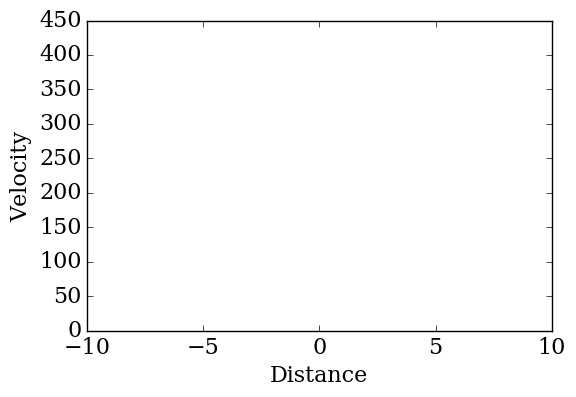

In [23]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(0,450.),xlabel=('Distance'),ylabel=('Velocity'));
line, = ax.plot([],[],color='#003366', lw=2);

In [24]:
anim = animation.FuncAnimation(fig, animate, frames=A_n[:,1], interval=50)
HTML(anim.to_html5_video())

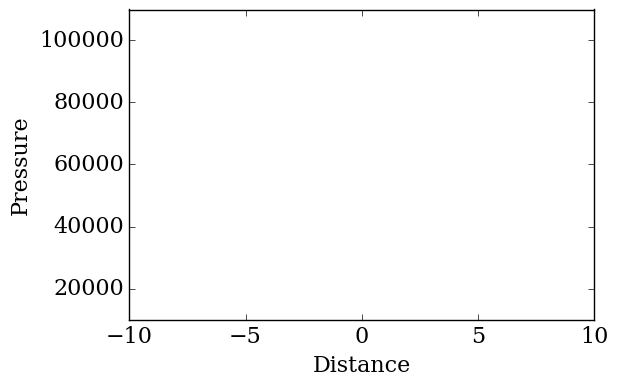

In [25]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(10000,110000.),xlabel=('Distance'),ylabel=('Pressure'));
line, = ax.plot([],[],color='#003366', lw=2);

In [26]:
anim = animation.FuncAnimation(fig, animate, frames=A_n[:,2], interval=50)
HTML(anim.to_html5_video())

Nous constations un curieux comportement sur les trois graphes en le point $x=0m$, l'emplacement de la membrane rigide. En effet nous aurions tendance à penser que la fonction de densité, vitesse ou pression serait une fonction plus lisse qu'elle ne le laisse paraître, car sur les animations où nous observons à chaque fois un pic en $x=0m$. Nous observons aussi deux vagues allant vers le coté droit qui fait penser aux même comportement que les méthodes de MacCormack et Lax-Wendroff montraient lorsqu'on utilisait $\frac{\Delta t}{\Delta x}=0,5$, comportement lié à la condition CFL comme expliqué dans la lesson 2 de ce module ci. Nous avons aussi une troisème vague se dirigeant vers la gauche qui correspond au gaz "fuyant" le coté gauche.

## Conclusion

Le comportement de la simulation fait exactement penser au comportement d'un gaz, se déplaçant afin d'occuper tout l'espace disponible. Ainsi les animations que nous observons nous paraissent logiques si ce n'est en le centre du tube même si ce "pic" (plus grand ou plus petit que les valeurs avoisinant le point) semble s'applatir au fil du temps.

La possible raison de ce comportement est que le centre du tube est l'endroit où le plus gros choc à lieu, le gaz se fraie un très rapide chemin (comme nous le montre le graphe de la vitesse) vers le coté moins dense du tube sans pour autant s'accumuler à cet endroit. Ceci nous faisant ressentir une sensation de "vide" au centre du tube dans le graphe de la densité et de la pression.